In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from libraries import helper_functions as hp

In [5]:
assert torch.cuda.is_available()

In [6]:
assert torch.backends.cudnn.enabled

# Settings

In [7]:
useTiff = False

In [8]:
path = "../data/"
train_dir = "train-tif-v2" if useTiff == True else "train-jpg"
test_dir = "test-tif-v2" if useTiff == True else 'test-merged'
csv = f'{path}train_v2.csv'
ext = ".tif" if useTiff == True else '.jpg'

In [9]:
load_model_from_disk = True

In [10]:
no_validation = True

In [11]:
val_idxs = [0] if no_validation else hp.val_idxs_from_csv(csv, load_from_disk=load_model_from_disk)

In [12]:
architecture = resnet34 #resnext101 # = resnext101_32

In [13]:
max_zoom = 1.05

In [14]:
dropout = 0.3

## Low Resolution

In [15]:
img_sz_low = 64
batch_sz_low = 200

## Medium Resolution

In [16]:
img_sz_med= 128
batch_sz_med = 100

## High Resolution

In [17]:
img_sz_high= 256
batch_sz_high = 64

## Helper Functions

In [18]:
def get_data(i_sz, b_sz):
    transforms = tfms_from_model(architecture, i_sz, transforms_top_down, max_zoom)
    data = ImageClassifierData.from_csv(path, train_dir, csv, b_sz, transforms, val_idxs, ext, test_dir)
    return transforms, data

In [19]:
def get_filename(label, layer, i_sz, b_sz):
    return f"{label}_{layer}_{i_sz}_{b_sz}{'_tiff' if useTiff else ''}{'_all' if no_validation else ''}"

# Pretrain with low resolution

In [20]:
tfms_low, data_low = get_data(img_sz_low, batch_sz_low)

In [21]:
learn = ConvLearner.pretrained(architecture, data_low, ps=dropout, precompute=False, metrics=[hp.f2_th])

## Train last layer

In [22]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                       
    0      0.295303   0.527388   0.5       



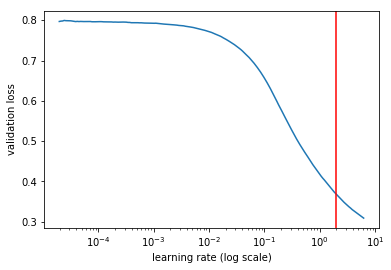

In [23]:
lr_low_last = 2
learn.sched.plot()
plt.axvline(x=lr_low_last, color="red")

In [24]:
learn.fit(lr_low_last, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                       
    0      0.150645   0.17427    0.714286  
    1      0.134908   0.201296   0.714286                    
    2      0.127002   0.143777   0.714286                    
    3      0.129647   0.195589   0.714286                    
    4      0.125074   0.095174   0.714286                    
    5      0.123061   0.112716   0.714286                    
    6      0.120596   0.11564    0.714286                    



[array([0.11564]), 0.7142857142857142]

In [25]:
low_lastlayer = get_filename("low", "last", img_sz_low, batch_sz_low); low_lastlayer

'low_last_64_200_all'

In [26]:
learn.save(low_lastlayer)

## Train all layers

In [27]:
learn.load(low_lastlayer)

In [28]:
learn.unfreeze()

In [29]:
torch.cuda.empty_cache()

In [30]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                       
    0      0.158642   5.081554   0.0       



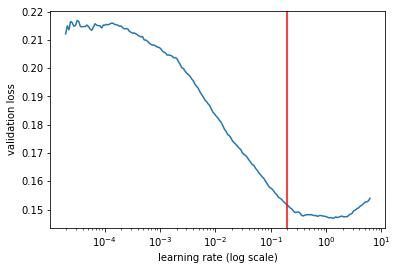

In [31]:
lr_low_all = 0.2
learn.sched.plot()
plt.axvline(x=lr_low_all, color="red")

In [32]:
lr_low_all=np.array([lr_low_all/9,lr_low_all/3,lr_low_all])
# satellite data is very different from imagenet --> train lower layers more aggressively

In [33]:
learn.fit(lr_low_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                       
    0      0.115778   0.103866   0.714286  
    1      0.10809    0.178366   0.714286                    
    2      0.102744   0.126673   0.714286                    
    3      0.101233   0.120352   0.714286                    
    4      0.098999   0.109575   0.714286                     
    5      0.094564   0.143265   0.714286                     
    6      0.094252   0.113211   0.714286                     



[array([0.11321]), 0.7142857142857142]

In [34]:
# image_size 64, batch_size 60: 2686mb (2448)
# image_size 64, batch_size 120, resnet34: 1525 mb

In [35]:
# batch_size 5: 2404mb (2299mb anaconda)
# batch_size 10: 3324mb (3086mb anaconda)
# batch_size 13: 3899mb (3571mb anaconda)

In [36]:
low_all = get_filename("low", "all", img_sz_low, batch_sz_low); low_all

'low_all_64_200_all'

In [37]:
learn.save(low_all)

# Medium Images

In [38]:
torch.cuda.empty_cache()

In [39]:
learn.load(low_all)

In [22]:
tfms_med, data_med = get_data(img_sz_med, batch_sz_med)

In [23]:
learn.set_data(data_med)

In [42]:
learn.freeze()

In [43]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                        
    0      0.108811   0.168415   0.714286  



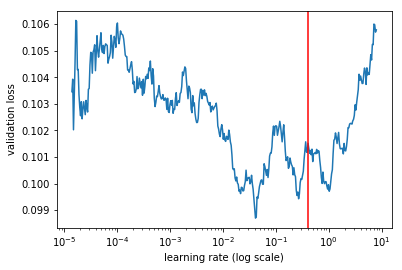

In [44]:
lr_med_last=4e-1
learn.sched.plot()
plt.axvline(x=lr_med_last, color="red")

In [45]:
learn.fit(lr_med_last, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.098309   0.190254   0.714286  
    1      0.096349   0.257748   0.714286                     
    2      0.095436   0.215601   0.714286                     
    3      0.094032   0.264148   0.5                          
    4      0.09571    0.210381   0.714286                     
    5      0.095137   0.242953   0.714286                     
    6      0.094033   0.23369    0.714286                     



[array([0.23369]), 0.7142857142857142]

In [46]:
med_lastlayer = get_filename("med", "last", img_sz_med, batch_sz_med); med_lastlayer

'med_last_128_100_all'

In [47]:
learn.save(med_lastlayer)

### all layers

In [48]:
torch.cuda.empty_cache()

In [49]:
learn.load(med_lastlayer)

In [50]:
learn.unfreeze()

In [51]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                        
    0      0.16898    0.819947   0.5       



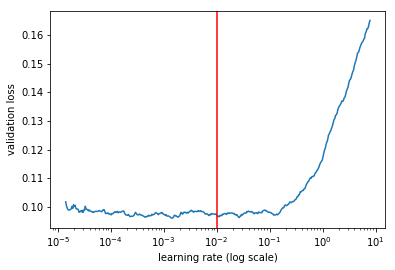

In [52]:
lr_med_all=1e-2
learn.sched.plot()
plt.axvline(x=lr_med_all, color="red")

In [53]:
lr_med_all = np.array([lr_med_all/9,lr_med_all/3,lr_med_all])
# model has been trained with satellite data already. can decrease learning_rate for low layers

In [54]:
learn.fit(lr_med_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.094411   0.227073   0.714286  
    1      0.092951   0.176779   0.714286                     
    2      0.091589   0.138475   0.714286                     
    3      0.092583   0.148079   0.714286                     
    4      0.091131   0.141118   0.714286                     
    5      0.090952   0.152184   0.714286                     
    6      0.090168   0.131464   0.714286                     



[array([0.13146]), 0.7142857142857142]

In [25]:
med_all = get_filename("med", "all", img_sz_med, batch_sz_med); med_all

'med_all_128_100_all'

In [56]:
learn.save(med_all)

# Large Images

In [57]:
torch.cuda.empty_cache()

In [26]:
learn.load(med_all)

In [27]:
tfms_high, data_high = get_data(img_sz_high, batch_sz_high)

In [28]:
learn.set_data(data_high)

In [29]:
learn.freeze()

In [62]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                        
    0      0.121651   0.051023   1.0       



In [30]:
lr_high_last=1e-2
learn.sched.plot()
plt.axvline(x=lr_high_last, color="red")

AttributeError: 'NoneType' object has no attribute 'plot'

In [31]:
learn.fit(lr_high_last, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.103445   0.163432   0.714286  
    1      0.100655   0.175753   0.714286                     
    2      0.102775   0.156992   0.714286                     
    3      0.101836   0.18758    0.714286                     
    4      0.101642   0.170004   0.714286                     
    5      0.098627   0.150223   0.714286                     
    6      0.100616   0.198974   0.714286                     



[array([0.19897]), 0.7142857142857142]

In [32]:
high_lastlayer = get_filename("high", "last", img_sz_high, batch_sz_high); high_lastlayer

'high_last_256_64_all'

In [33]:
learn.save(high_lastlayer)

### all layers

In [34]:
torch.cuda.empty_cache()

In [35]:
learn.load(high_lastlayer)

In [36]:
learn.unfreeze()

In [37]:
learn.lr_find()

epoch      trn_loss   val_loss   f2_th                        
    0      0.18474    0.103821   0.714286  



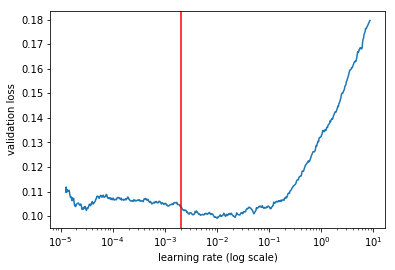

In [38]:
lr_high_all=2e-3
learn.sched.plot()
plt.axvline(x=lr_high_all, color="red")

In [39]:
lr_high_all = np.array([lr_high_all/9,lr_high_all/3,lr_high_all])
# model has been trained with satellite data already. can decrease learning_rate for low layers

In [41]:
learn.fit(lr_high_all, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2_th                        
    0      0.102247   0.186123   0.714286  
    1      0.098982   0.191406   0.714286                     
    2      0.09936    0.206001   0.714286                     
    3      0.096372   0.126686   0.714286                     
    4      0.092726   0.144751   0.714286                     
    5      0.09371    0.220853   0.714286                     
    6      0.096043   0.120564   0.714286                     



[array([0.12056]), 0.7142857142857142]

In [40]:
high_all = get_filename("high", "all", img_sz_high, batch_sz_high); high_all

'high_all_256_64_all'

In [42]:
learn.save(high_all)

# Find proper threshold

In [43]:
learn.load(high_all)

In [44]:
val_probs, val_true = learn.TTA()

In [45]:
val_prob = np.average(val_probs, axis=0)

In [46]:
th = hp.get_threshold(val_prob, val_true, stop=1);th 

0.6699999999999997

In [47]:
# Hier stirbt der Kernel!

In [48]:
hp.f2(val_true, val_prob>th)

0.8333333333333334

# Submission

In [49]:
probs_test, true_test = learn.TTA(is_test=True)

In [50]:
probs_test = np.average(probs_test, axis=0)

In [51]:
submission = hp.create_submission(probs_test, data_high, th)

In [52]:
submission_file = f"submission_{img_sz_low}_{batch_sz_low}_{img_sz_med}_{batch_sz_med}_{img_sz_high}_{batch_sz_high}{'_tiff' if useTiff else ''}{'_all' if no_validation else ''}"

In [53]:
submission.to_csv(submission_file, index=False)

In [54]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {submission_file} -m "img_sz_low={img_sz_low}, bs_low={batch_sz_low}, img_sz_high={img_sz_high}, bs_high={batch_sz_high}"

Successfully submitted to Planet: Understanding the Amazon from Space